## Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)
```
Conditional Deep Convolutional Generative Adversarial Network (cDCGAN) is a GAN that uses convolutional layers in the discriminator and generator. It allows class-conditioning of the generated images. This means that we can specify which class of image we want to generate.
```

In [1]:
# necessary imports
# add ../src to sys.path
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm, trange

import cDCGAN

In [2]:
# load MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transform)


# data loaders
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

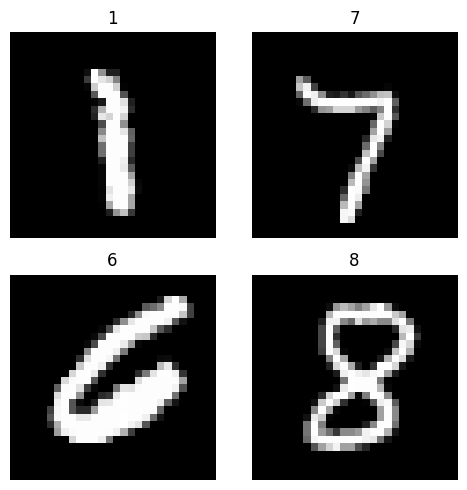

In [3]:
# visualize some data
def visualize_data(data, labels):
    fig, axs = plt.subplots(2,2, figsize=(5,5))
    axs = axs.flatten()
    for i in range(4):
        axs[i].imshow(data[i].squeeze(), cmap='gray')
        axs[i].set_title(labels[i].item())
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# visualize some data
imgs, labels = next(iter(trainloader))
visualize_data(imgs, labels)

In [4]:
# max and min values of the data
print('max: ', torch.max(imgs))
print('min: ', torch.min(imgs))

max:  tensor(1.)
min:  tensor(-1.)


In [5]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# noise dim
noise_dim = 100

# number of classes
num_classes = np.unique(labels).shape[0]

In [10]:
# create generator and discriminator models
generator = cDCGAN.cGenerator(noise_dim, num_classes).to(device)
discriminator = cDCGAN.cDiscriminator(num_classes).to(device)

In [11]:
# test generator
noise = torch.randn(32, noise_dim).to(device)
labels = torch.randint(0, num_classes, (32,)).to(device)
fake_imgs = generator(noise, labels)
print(fake_imgs.shape)

# test discriminator
preds = discriminator(fake_imgs, labels)
print(preds.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1])


In [12]:
# optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# loss function
criterion = nn.BCELoss()

In [13]:
# training loop
epochs = 200
for epoch in trange(epochs):
    for i, (real_imgs, real_labels) in enumerate(trainloader):
        
        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)

        # train discriminator
        optimizer_D.zero_grad()
        # real data
        real_preds = discriminator(real_imgs, real_labels)
        real_loss = criterion(real_preds, torch.ones_like(real_preds))
        # fake data
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_imgs = generator(noise, fake_labels)
        fake_preds = discriminator(fake_imgs, fake_labels)
        fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
        # total loss
        loss_D = real_loss + fake_loss
        loss_D.backward()
        optimizer_D.step()

        # train generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        fake_imgs = generator(noise, fake_labels)
        fake_preds = discriminator(fake_imgs, fake_labels)
        loss_G = criterion(fake_preds, torch.ones_like(fake_preds))
        loss_G.backward()
        optimizer_G.step()

    # print losses
    if epoch % 20 == 0:
        print('epoch: ', epoch, 'loss_D: ', loss_D.item(), 'loss_G: ', loss_G.item())

  0%|          | 1/200 [00:11<38:38, 11.65s/it]

epoch:  0 loss_D:  0.21963319182395935 loss_G:  3.8592677116394043


 10%|█         | 21/200 [04:00<34:16, 11.49s/it]

epoch:  20 loss_D:  0.3983180522918701 loss_G:  1.716791033744812


 20%|██        | 41/200 [07:50<30:29, 11.50s/it]

epoch:  40 loss_D:  0.7321686744689941 loss_G:  2.063819408416748


 30%|███       | 61/200 [11:41<26:40, 11.52s/it]

epoch:  60 loss_D:  0.2351813018321991 loss_G:  2.166663646697998


 40%|████      | 81/200 [15:47<25:17, 12.76s/it]

epoch:  80 loss_D:  0.7603467702865601 loss_G:  2.1880812644958496


 50%|█████     | 101/200 [19:47<19:41, 11.94s/it]

epoch:  100 loss_D:  0.3655305504798889 loss_G:  4.618119239807129


 60%|██████    | 121/200 [24:00<15:02, 11.42s/it]

epoch:  120 loss_D:  0.31561967730522156 loss_G:  6.496908187866211


 70%|███████   | 141/200 [27:47<11:27, 11.65s/it]

epoch:  140 loss_D:  0.13981465995311737 loss_G:  4.8753180503845215


 80%|████████  | 161/200 [31:35<07:28, 11.50s/it]

epoch:  160 loss_D:  0.1263108253479004 loss_G:  4.2047600746154785


 90%|█████████ | 181/200 [35:33<03:44, 11.80s/it]

epoch:  180 loss_D:  4.185004234313965 loss_G:  0.07471683621406555


100%|██████████| 200/200 [39:14<00:00, 11.77s/it]


In [14]:
# generate some data
noise = torch.randn(32, noise_dim).to(device)
labels = torch.randint(0, num_classes, (32,)).to(device)
fake_imgs = generator(noise, labels).detach().cpu().numpy()

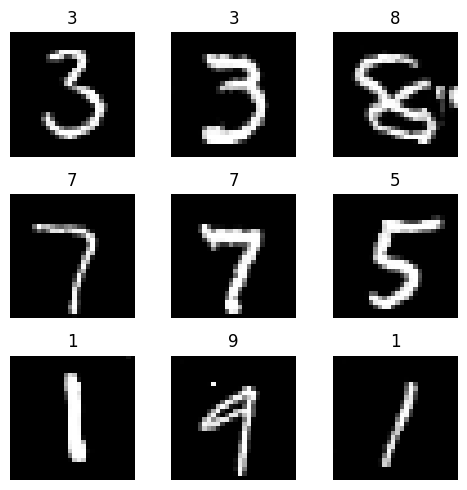

In [15]:
# visualize some generated data, 3x3 grid
fig, axs = plt.subplots(3,3, figsize=(5,5))
axs = axs.flatten()
for i in range(9):
    axs[i].imshow(fake_imgs[i].reshape(28,28), cmap='gray')
    axs[i].set_title(labels[i].item())
    axs[i].axis('off')
plt.tight_layout()
plt.show()


```
Nicely done! The results look much better than cGAN. Longer training, plus better hyperparameters will improve the results even further.
```